# Libraries

In [1]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from functions.graph_tools import *
from models.nmf import *
from functions import cosmic_val
from functions import data_handling as dh

# set seed
np.random.seed(17)

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed/Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [ ]:
LATENT_DIM = 4
TOLERANCE = 1e-4
MAX_ITERATIONS = 100_000_000
SPLIT = 0.8


(96, 418)
(96, 105)


In [ ]:
losses_train = []
losses_test = []
signatures = []
iterations = 30


for i in tqdm(range(iterations)):


    # Extract train and test data
    train_data = data.sample(frac = SPLIT, axis = 1)
    test_data = data.drop(train_data.columns, axis = 1)

    
    # Applying NMF
    signatures_nmf, exposures_nmf, loss_nmf = nmf(catalog_matrix = train_data.to_numpy(),
                                                  num_sign = LATENT_DIM,
                                                  tol = TOLERANCE,
                                                  max_iter = MAX_ITERATIONS)
    

    # Refitting NMF (test data)

    losses_refit = refit_NMF(test_data.to_numpy(), signatures_nmf)
    losses_test.append(losses_refit[-1])

    # Calculating signatures and exposures for NMF
    diagonals_nmf = signatures_nmf.sum(axis=0)
    exposures_nmf = exposures_nmf.T @ np.diag(diagonals_nmf)
    signatures_nmf = (signatures_nmf) @ np.diag(1 / diagonals_nmf)
    
    losses_train.append(loss_nmf[-1])
    signatures.append(signatures_nmf)



100%|██████████| 30/30 [18:59<00:00, 38.00s/it]


In [7]:
print("Losses train: ", np.mean(losses_train))
print("Losses test: ", np.mean(losses_test))

Losses train:  14767.756462607276
Losses test:  104970.31351827513


In [8]:
all_signatures = np.hstack(signatures)

In [10]:
pam = KMedoids(n_clusters = LATENT_DIM, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

In [11]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic, index = 0)

In [12]:
print(matched_signatures.head())
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted_0  True_0  Similarity_0
0            0  SBS40a      0.741773
1            1   SBS44      0.846296
2            2  SBS10c      0.689775
3            3  SBS10a      0.931508

Mean similarity of the matched signatures:  0.8023378616029833


In [13]:
all_matches = cosmic_val.compute_all_matches(all_signatures, cosmic, k = 4)

In [14]:
all_matches

,True_0,Similarity_0,True_1,Similarity_1,True_2,Similarity_2,True_3,Similarity_3,True_4,Similarity_4,...,True_25,Similarity_25,True_26,Similarity_26,True_27,Similarity_27,True_28,Similarity_28,True_29,Similarity_29
0,SBS13,0.704850,SBS40a,0.722636,SBS10c,0.757032,SBS40a,0.731632,SBS10a,0.931542,...,SBS10c,0.668245,SBS44,0.817371,SBS44,0.846296,SBS10a,0.929631,SBS13,0.776228
1,SBS10a,0.928689,SBS10c,0.737527,SBS44,0.810551,SBS10c,0.689775,SBS10c,0.666709,...,SBS13,0.706048,SBS3,0.914659,SBS10a,0.931536,SBS3,0.741525,SBS3,0.914917
2,SBS6,0.902744,SBS6,0.909968,SBS3,0.729557,SBS10a,0.931628,SBS44,0.850464,...,SBS10a,0.931675,SBS6,0.924193,SBS40a,0.716544,SBS44,0.859346,SBS6,0.913693
3,SBS40c,0.775434,SBS44,0.851826,SBS10a,0.931457,SBS44,0.838828,SBS40a,0.736449,...,SBS44,0.846598,SBS13,0.800600,SBS10c,0.748048,SBS10c,0.663416,SBS44,0.892672


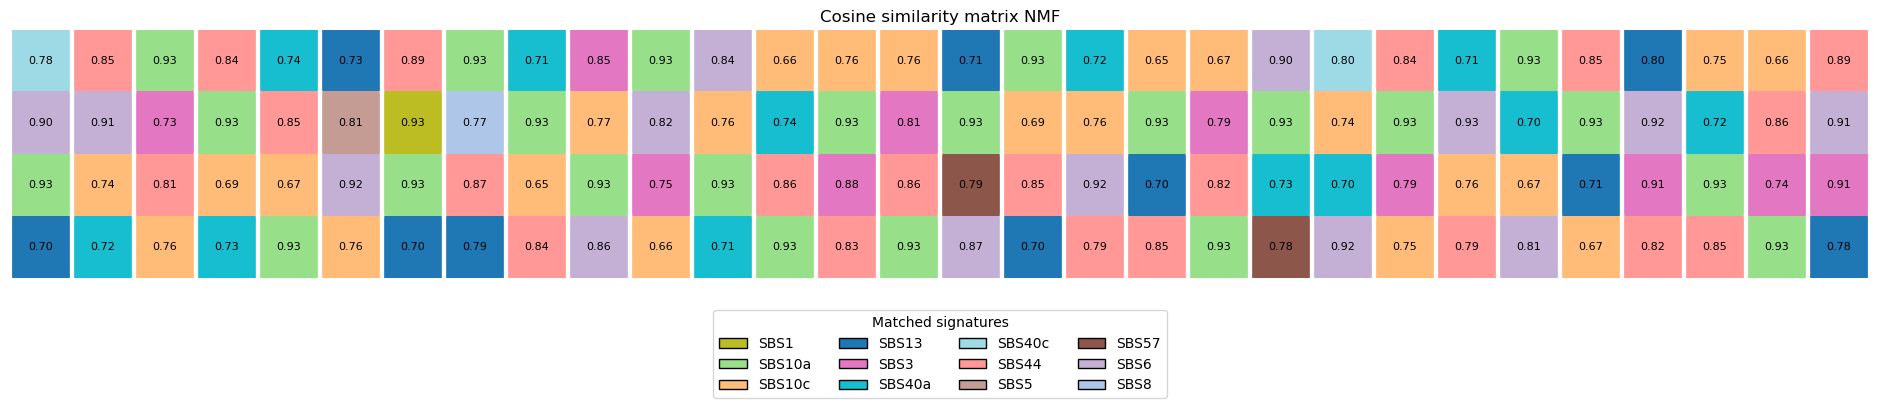

In [15]:
plot_cosine_similarity_matrix(all_matches, title = "Cosine similarity matrix NMF", figsize=(24, 12), legend_colums=4, palette='tab20')

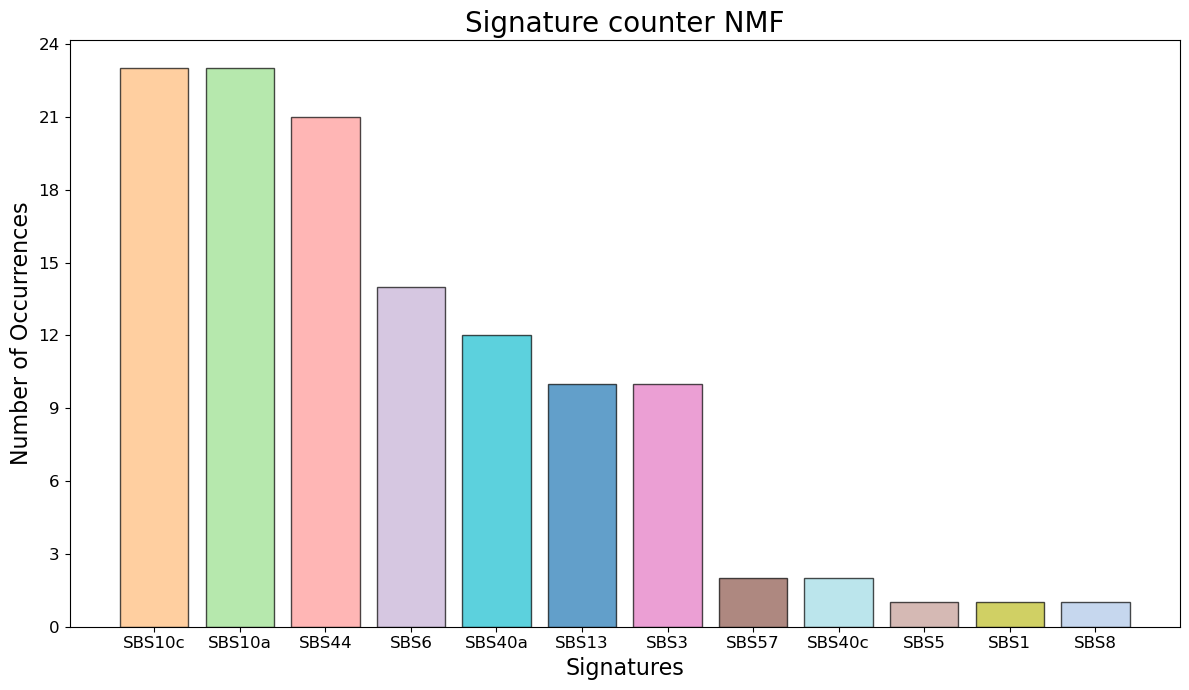

In [16]:
plot_signature_frequency(all_matches, title = "Signature counter NMF", figsize=(12,7), color='tab20')

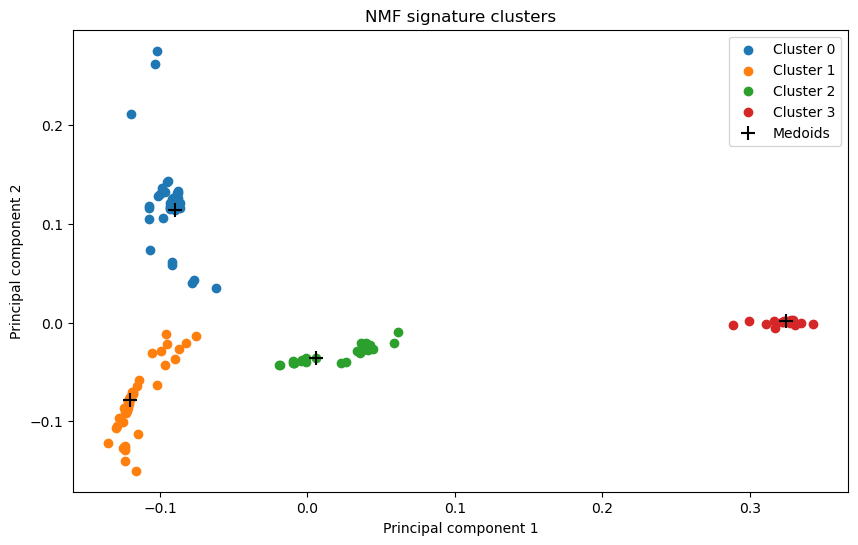

In [17]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)
plot_clusters(reduced_signatures, labels, medoid_indices, 4, "NMF signature clusters")

In [18]:
df_consensus = pd.DataFrame(consensus_signatures, index = data.index)

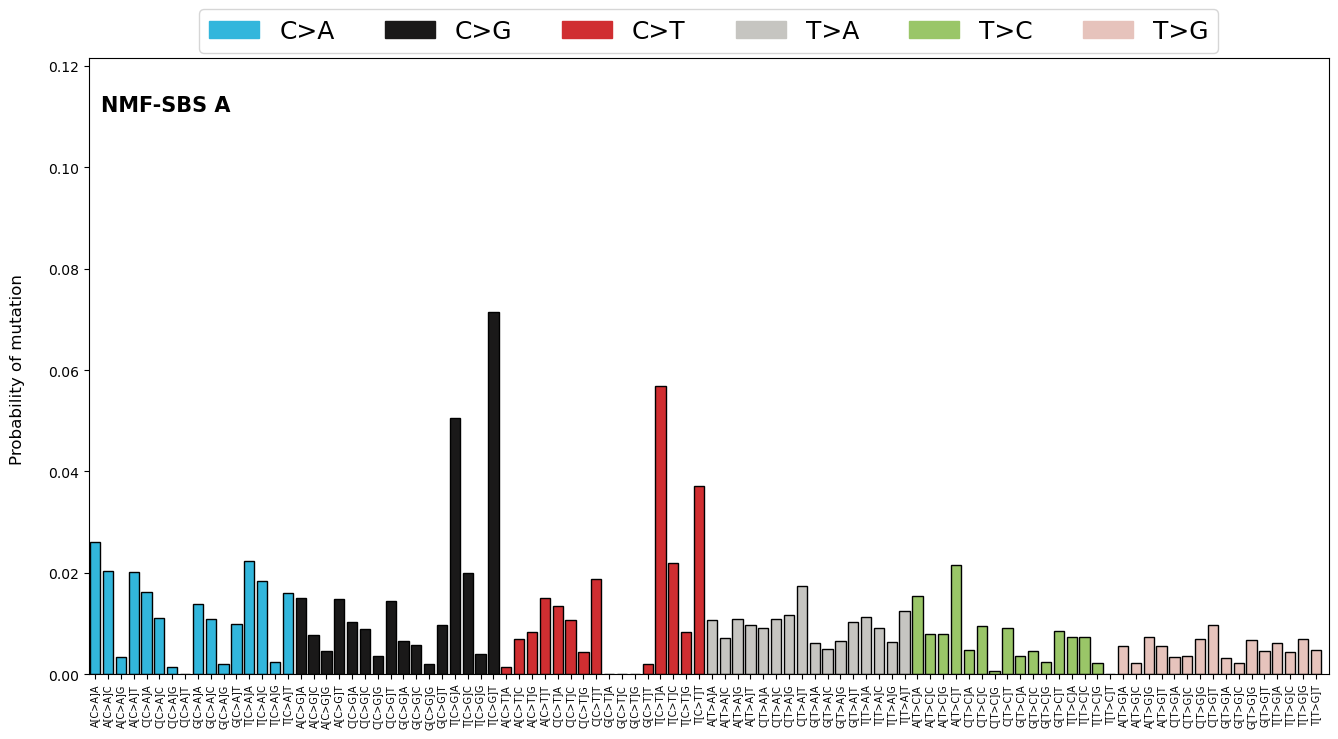

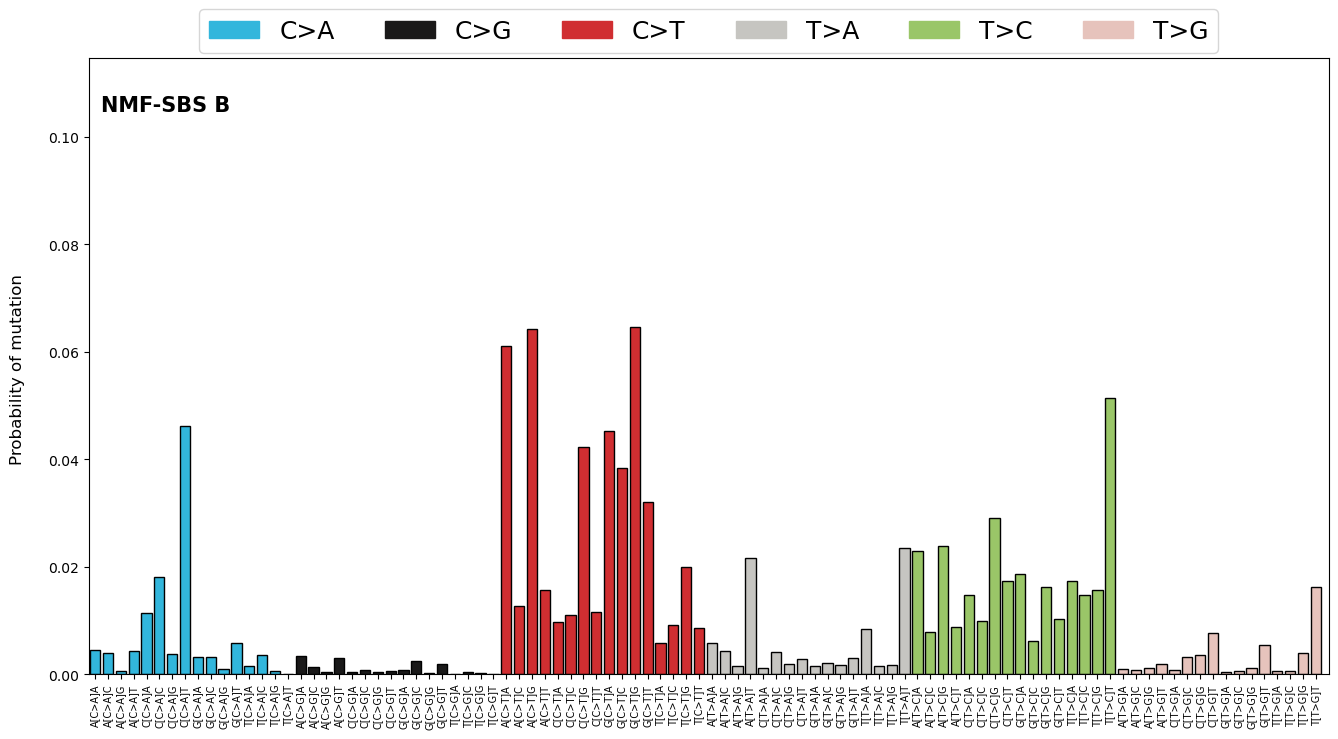

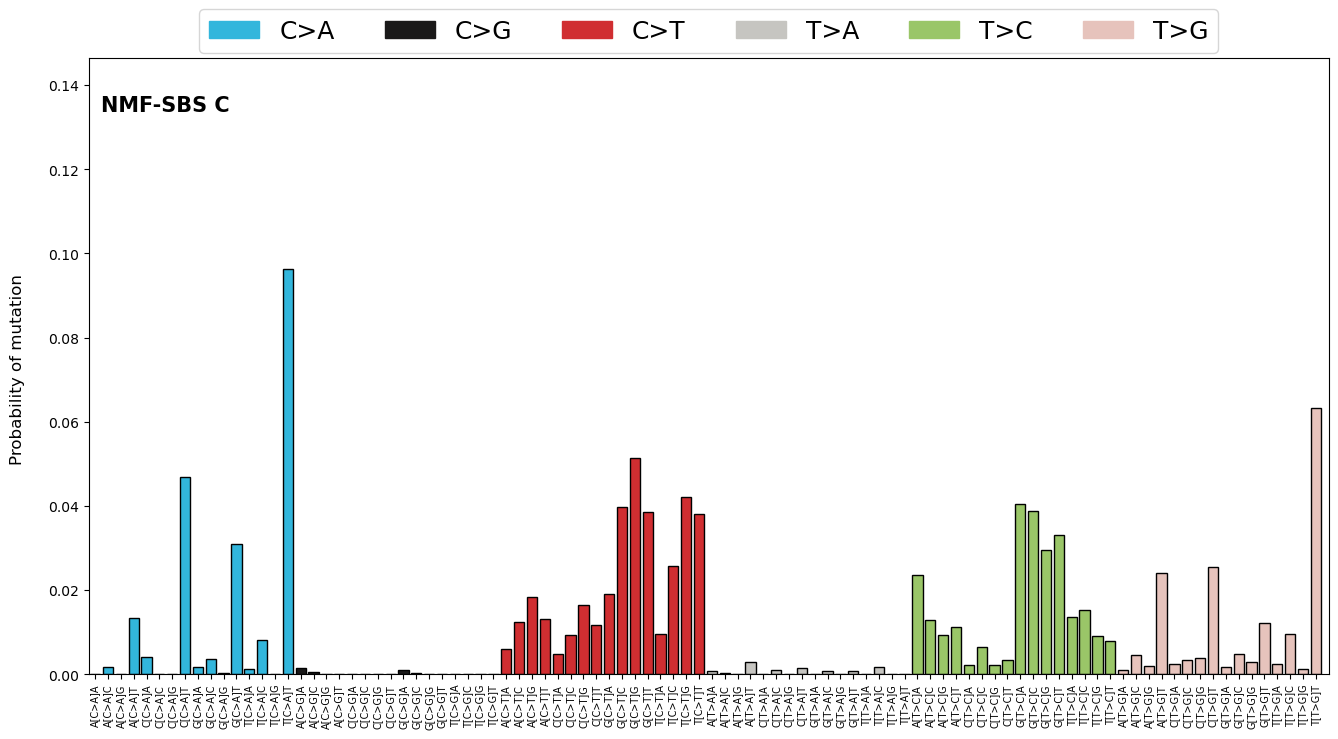

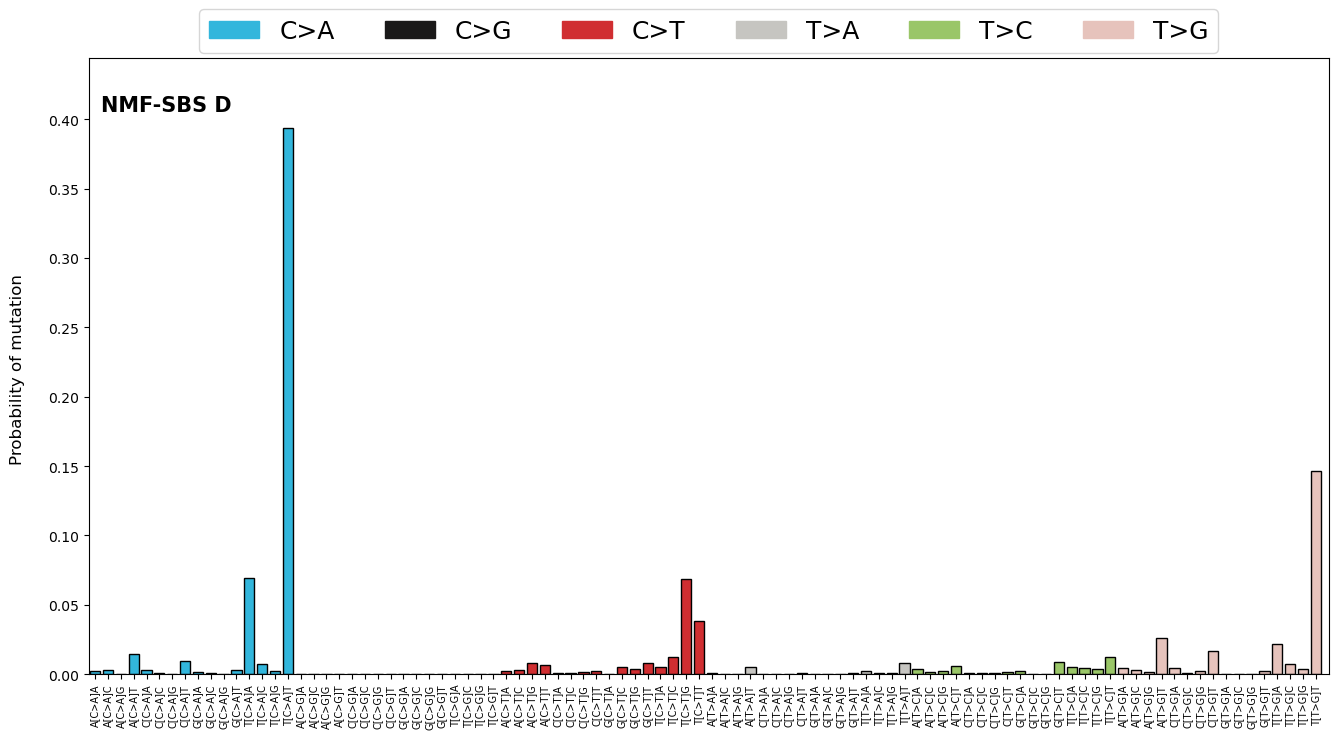

In [19]:
plot_signature(df_consensus, "NMF")